In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [12]:
df = pd.read_excel('/content/1730285881-Airbnb_Open_Data (1).xlsx')
df.head()


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,124.0,3.0,0.0,NaT,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,74.0,30.0,270.0,2019-07-05,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,41.0,10.0,9.0,2018-11-19,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [13]:
# Drop duplicate records
df.drop_duplicates(inplace=True)

# Drop columns with insufficient data if they exist
cols_to_drop = [c for c in ['house_rules', 'license'] if c in df.columns]
if cols_to_drop:
    df.drop(cols_to_drop, axis=1, inplace=True)

# Remove currency symbols and commas from price and service fee columns (if present)
for col in ['price', 'service fee']:
    if col in df.columns:
        # remove '$' and ',' literally (no regex patterns)
        df[col] = (
            df[col]
            .astype(str)
            .str.replace('$', '', regex=False)
            .str.replace(',', '', regex=False)
        )

# Rename the price and service fee columns to include a dollar indicator in the name
rename_map = {}
if 'price' in df.columns:
    rename_map['price'] = 'price_$'
if 'service fee' in df.columns:
    rename_map['service fee'] = 'service_fee_$'
if rename_map:
    df.rename(columns=rename_map, inplace=True)

# Drop records with any missing values (optional; mirrors the screenshots)
df.dropna(inplace=True)

# Fix data types where applicable, only if the columns are present
if 'price_$' in df.columns:
    df['price_$'] = pd.to_numeric(df['price_$'], errors='coerce')

if 'service_fee_$' in df.columns:
    df['service_fee_$'] = pd.to_numeric(df['service_fee_$'], errors='coerce')

for col in ['id', 'host id']:
    if col in df.columns:
        df[col] = df[col].astype(str)

if 'last review' in df.columns:
    df['last review'] = pd.to_datetime(df['last review'], errors='coerce')

if 'construction year' in df.columns:
    df['construction year'] = pd.to_numeric(df['construction year'], errors='coerce').astype('Int64')

# Correct spelling in neighbourhood group (brookln -> Brooklyn)
if 'neighbourhood group' in df.columns:
    df.loc[df['neighbourhood group'] == 'brookln', 'neighbourhood group'] = 'Brooklyn'

# Remove outliers in availability 365 (> 500), if column exists
if 'availability 365' in df.columns:
    df = df.drop(df[df['availability 365'] > 500].index)

# Duplicate check
print("Duplicate rows count:")
print(df.duplicated().value_counts())

#describe
df.describe()

# Property types (room types) frequency as a DataFrame
if 'room type' in df.columns:
    property_types = df['room type'].value_counts().to_frame('count')
    print("\nProperty types (room type) counts:")
    print(property_types)



Duplicate rows count:
False    83796
Name: count, dtype: int64

Property types (room type) counts:
                 count
room type             
Entire home/apt  44367
Private room     37664
Shared room       1655
Hotel room         110


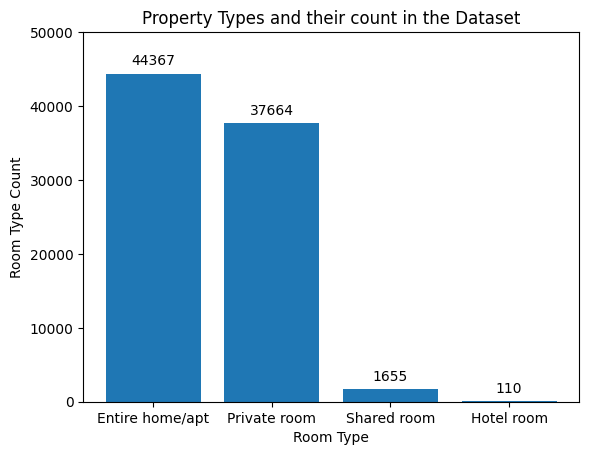

In [14]:
# Create the bars
room_type_bar = plt.bar(property_types.index, property_types.loc[:, 'count'])

# Put the counts as labels on each bar
plt.bar_label(room_type_bar, labels=property_types.loc[:, 'count'], padding=4)

# Y-axis limit similar to the screenshot
plt.ylim(0, 50000)

# Axis labels and title
plt.xlabel('Room Type')
plt.ylabel('Room Type Count')
plt.title('Property Types and their count in the Dataset')

# Render the figure (useful in some environments)
plt.show()

In [15]:
# Which neighborhood group has the highest number of listings?
hood_group = df['neighbourhood group'].value_counts().to_frame('count')
hood_group

,count
neighbourhood group,
Brooklyn,34780
Manhattan,34735
Queens,11184
Bronx,2276
Staten Island,821


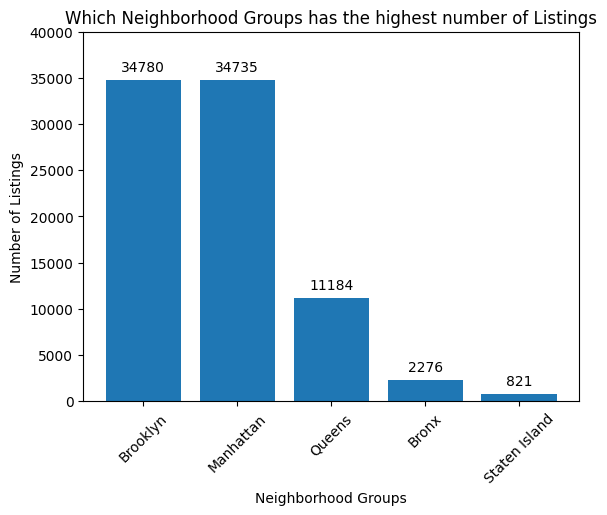

In [16]:
#which neighbourhood group had highest number of listings
hood_group_bar = plt.bar(hood_group.index, hood_group.loc[:, 'count'])
plt.bar_label(hood_group_bar, labels=hood_group.loc[:, 'count'], padding=4)

plt.ylim(0, 40000)
plt.xlabel('Neighborhood Groups')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.title('Which Neighborhood Groups has the highest number of Listings')

plt.show()

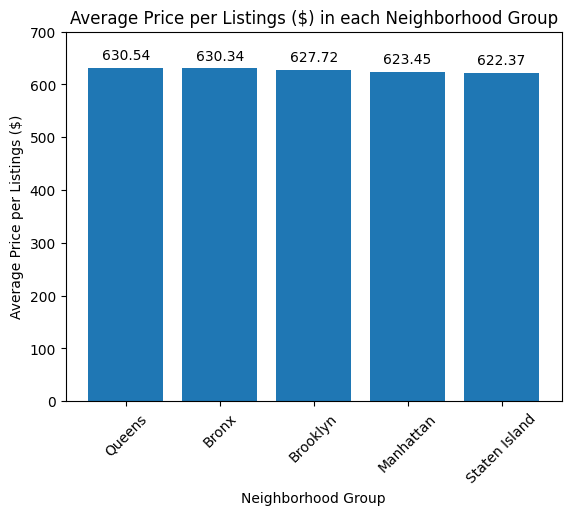

In [17]:
# Which neighborhoods group have the highest average prices for Airbnb listings?
avg_price = df.groupby('neighbourhood group')['price_$'].mean().sort_values(ascending=False).to_frame('price_$')

avg_price_bar = plt.bar(avg_price.index, avg_price.loc[:, 'price_$'])
plt.bar_label(avg_price_bar, labels=round(avg_price.loc[:, 'price_$'], 2), label_type='edge', padding=4)

plt.ylim(0, 700)
plt.xlabel('Neighborhood Group')
plt.ylabel('Average Price per Listings ($)')
plt.xticks(rotation=45)
plt.title('Average Price per Listings ($) in each Neighborhood Group')

plt.show()


In [18]:
# Is there a relationship between the construction year of property and price?
if 'construction year' in df.columns:
    df.groupby(df['construction year'])['price_$'].mean().to_frame().plot();

    plt.xlabel('Construction Year');
    plt.ylabel('Average Price ($)');
    plt.title('Average Price ($) for Properties in each Construction Year');

    plt.show()
else:
    print("The 'construction year' column is not present in the DataFrame.")

The 'construction year' column is not present in the DataFrame.


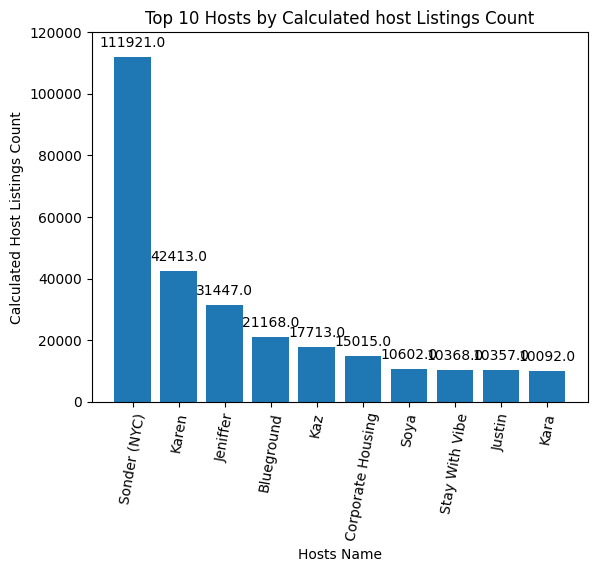

In [19]:
# Who are the top 10 hosts by calculated host listing count?
hosts = (
    df.groupby('host name')['calculated host listings count']
      .sum()
      .sort_values(ascending=False)
      .nlargest(10)
      .to_frame('calculated host listings count')
)

hosts_bar = plt.bar(hosts.index, hosts.loc[:, 'calculated host listings count'])
plt.bar_label(hosts_bar, labels=hosts.loc[:, 'calculated host listings count'], label_type='edge', padding=5)

plt.xlabel('Hosts Name')
plt.ylabel('Calculated Host Listings Count')
plt.xticks(rotation=80)
plt.ylim(0, 120000)
plt.title('Top 10 Hosts by Calculated host Listings Count')

plt.show()


In [20]:
# Are hosts with verified identities more likely to receive positive reviews?
review = (
    df.groupby('host_identity_verified')['review rate number']
      .mean()
      .sort_values(ascending=False)
      .to_frame()
)
review


,review rate number
host_identity_verified,
verified,3.283856
unconfirmed,3.273786


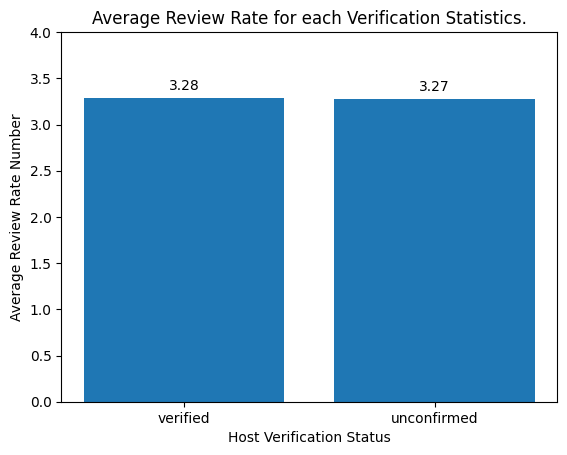

In [21]:
review_bar = plt.bar(review.index, review.loc[:, 'review rate number'])
plt.bar_label(review_bar, labels=round(review.loc[:, 'review rate number'], 2), padding=4)

plt.ylim(0, 4)
plt.xlabel('Host Verification Status')
plt.ylabel('Average Review Rate Number')
plt.title('Average Review Rate for each Verification Statistics.')

plt.show()

In [22]:
# Is there a correlation between the price of a listing and its service fee?
df['price_$'].corr(df['service_fee_$'])


np.float64(0.9999909082976466)

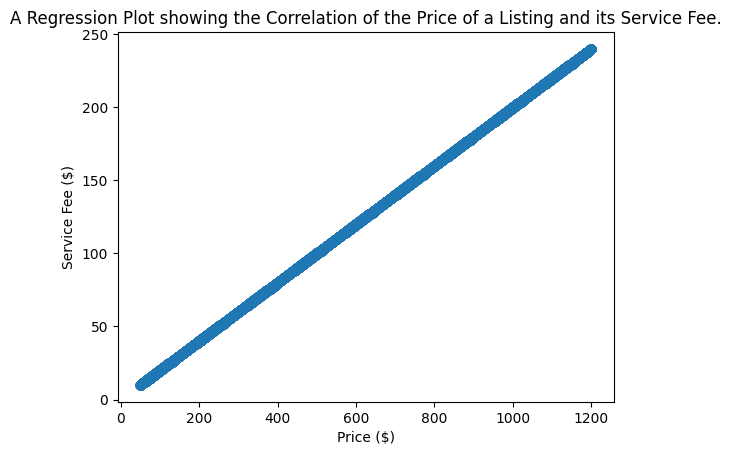

In [23]:
sns.regplot(data=df, x='price_$', y='service_fee_$')
plt.xlabel('Price ($)')
plt.ylabel('Service Fee ($)')
plt.title('A Regression Plot showing the Correlation of the Price of a Listing and its Service Fee.')

plt.show()

In [24]:
# What is the average review rate number (e.g., stars) for listings,
# and does it vary based on the neighborhood group and room type?
ARRN = df.groupby(['neighbourhood group', 'room type'])['review rate number'].mean().to_frame()
ARRN


review rate number
neighbourhood group room type                          
Bronx               Entire home/apt            3.379863
                    Private room               3.312548
                    Shared room                3.356322
Brooklyn            Entire home/apt            3.243013
                    Hotel room                 3.833333
                    Private room               3.274774
                    Shared room                3.322368
Manhattan           Entire home/apt            3.268940
                    Hotel room                 3.500000
                    Private room               3.285628
                    Shared room                3.252976
Queens              Entire home/apt            3.347437
                    Hotel room                 3.750000
                    Private room               3.311761
                    Shared room                3.327402
Staten Island       Entire home/apt            3.334129
                    Private room               3.493671
                    Shared room                3.714286

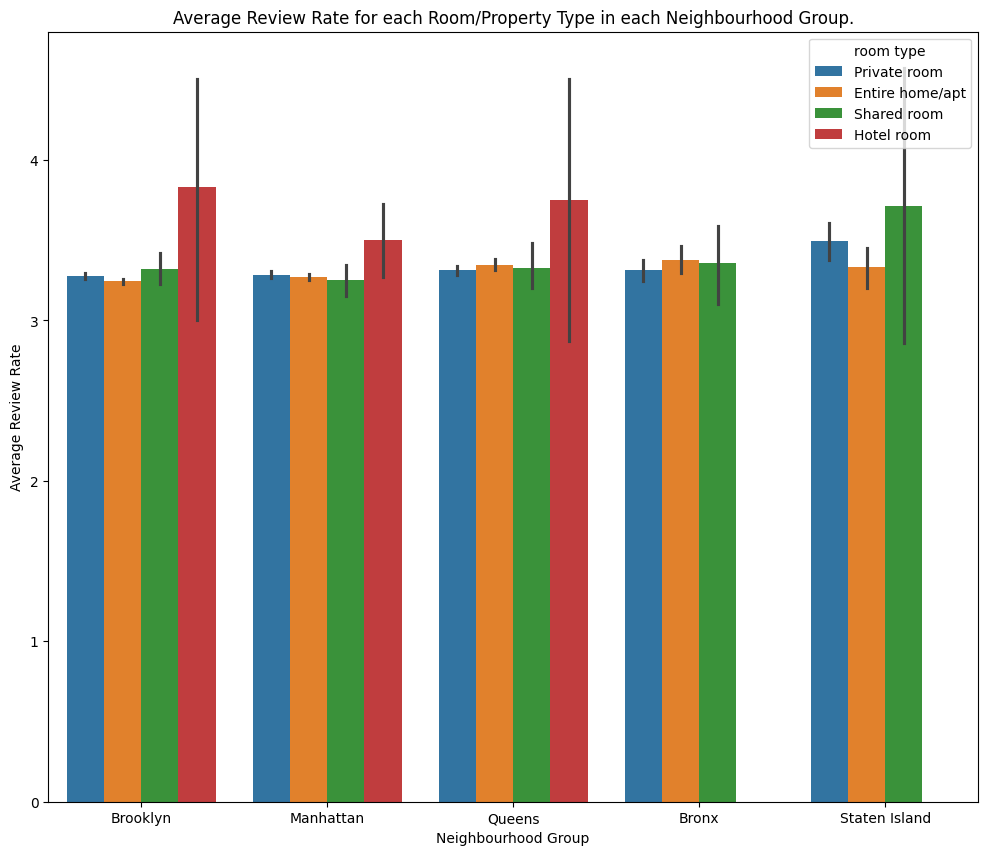

In [25]:
plt.figure(figsize=(12, 10))
sns.barplot(data=df, x='neighbourhood group', y='review rate number', hue='room type')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Review Rate')
plt.title('Average Review Rate for each Room/Property Type in each Neighbourhood Group.')

plt.show()

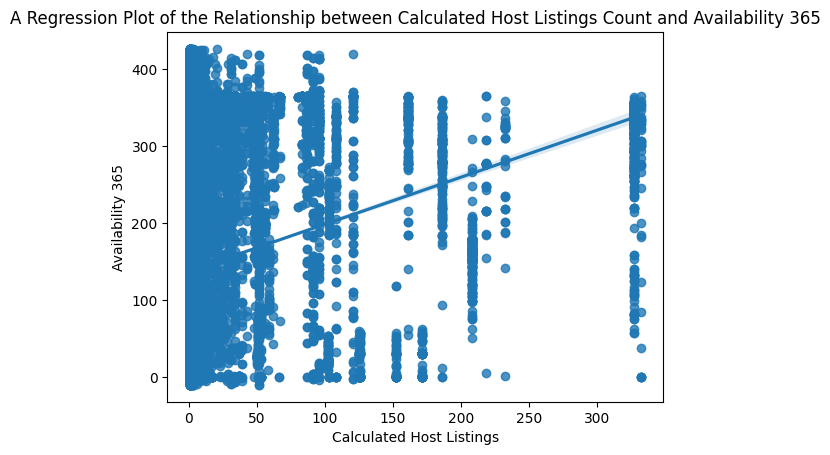

In [26]:
# Are hosts with a higher calculated host listings count more likely to maintain higher availability throughout the year?
sns.regplot(data=df, x='calculated host listings count', y='availability 365')
plt.xlabel('Calculated Host Listings')
plt.ylabel('Availability 365')
plt.title('A Regression Plot of the Relationship between Calculated Host Listings Count and Availability 365')

plt.show()

In [27]:
df['calculated host listings count'].corr(df['availability 365'])

np.float64(0.1353372562905428)